In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from phonopy import Phonopy
import phonopy.interface.vasp as Intf_vasp
from phonopy.structure.atoms import PhonopyAtoms
import phonopy.file_IO as PhonIO
from phonopy.interface.calculator import get_default_physical_units
from phonopy.interface.alm import get_fc2
import os
import shutil
import API_quippy_phonopy_VASP as api_qpv
import API_alamode as api_alm
import sys
import API_quippy_thirdorder as shengfc3
import thirdorder_core
import thirdorder_common

In [2]:
Qpoints=np.array([[1e-4,1e-4,1.0],[0.5,0.5,1.0],[3./8,3./8,3./4],[0.0,0.0,0.0],[0.5,0.5,0.5]])
band_labels=['$\Gamma$','X','K','$\Gamma$','L']
#Qpoints = np.array([[0.5,0.0,0.0],[0,0,0],[2./3,1./3,0.0]])
#band_labels = ['M','$\Gamma$','K']
Ncells=[4,4,4] # Need to be consistent with the size one used to generate random displacements in DFSET
Band_points=100
NAC = True
interface_mode = 'vasp'
nneigh = 4 #neighbor cutoff for 3rd order force constants.

In [3]:
Unit_cell = Intf_vasp.read_vasp("POSCAR") # read prim cell from the POSCAR file
prim_mat = np.eye(3)#[[0, 0.5, 0.5],[0.5, 0, 0.5],[0.5, 0.5, 0]]
phonon = Phonopy(Unit_cell,np.diag(Ncells),primitive_matrix=prim_mat) # generate an phononpy object for LD calc.

In [4]:
if os.path.exists('DFSET'):
    DFSET = np.loadtxt('DFSET')
    displacements=DFSET[:,0:3]
    forces=DFSET[:,3:6]
    Natoms = phonon.get_supercell().get_number_of_atoms()
    Nat_scells,DIM = forces.shape
    Nsnaps = int(Nat_scells/Natoms)
    forces=forces.reshape([Nsnaps,Natoms,3])
    displacements=displacements.reshape([Nsnaps,Natoms,3])

else:
    print("Cannot find DFSET!")

In [5]:
# Get frange for third order force constants:
poscar = shengfc3.read_POSCAR(".")
sposcar = shengfc3.gen_SPOSCAR(poscar, Ncells[0], Ncells[1], Ncells[2])
dmin, nequi, shifts = shengfc3.calc_dists(sposcar)
frange = shengfc3.calc_frange(poscar, sposcar, nneigh, dmin)*10 # get cutoff from 

In [6]:
options ='solver = dense, cutoff = '+str(frange)
FC2,FC3 = api_alm.get_fc2_fc3(phonon,displacements,forces,is_compact_fc=False,options=options,log_level=1)

#thirdorder_common.write_ifcs(FC3, poscar, sposcar, dmin, nequi, shifts, frange,"FORCE_CONSTANTS_3RD")

--------------------------------- ALM start --------------------------------
ALM is a non-trivial force constants calculator. Please cite the paper:
T. Tadano and S. Tsuneyuki, J. Phys. Soc. Jpn. 87, 041015 (2018).
ALM is developed at https://github.com/ttadano/ALM by T. Tadano.
Increase log-level to watch detailed ALM log.
fc2
cutoff     Na     Cl
   Na   -1.00  -1.00
   Cl   -1.00  -1.00
fc3
cutoff     Na     Cl
   Na    5.99   5.99
   Cl    5.99   5.99
---------------------------------- ALM end ---------------------------------


In [7]:
api_qpv.write_ShengBTE_FC2(FC2, filename='FORCE_CONSTANTS_2ND')
prim = api_qpv.phonopyAtoms_to_aseAtoms(phonon.get_primitive())
api_alm.write_shengBTE_fc3('FORCE_CONSTANTS_3RD',FC3,phonon,prim)

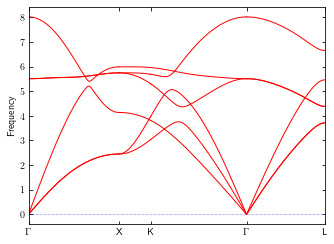

In [8]:
phonon.set_force_constants(FC2)
if NAC == True:
    nac_params = PhonIO.get_born_parameters(
            open("BORN"),
            phonon.get_primitive(),
            phonon.get_primitive_symmetry())
    if nac_params['factor'] == None:
        physical_units = get_default_physical_units(interface_mode)
        nac_params['factor'] = physical_units['nac_factor']
    phonon._nac_params=nac_params
    phonon._set_dynamical_matrix()
    
bands=api_qpv.qpoints_Band_paths(Qpoints,Band_points)
phonon.set_band_structure(bands,is_eigenvectors=True,labels=band_labels)
phonon.write_yaml_band_structure()
bs_plt=phonon.plot_band_structure()
bs_plt.xlabel("")
bs_plt.ylabel("Frequency (THz)",fontsize=16)
bs_plt.xticks(fontsize=16)
bs_plt.yticks(fontsize=16)
bs_plt.savefig("Bandstructure.png",dpi=300,bbox_inches='tight')